## Load Cleaned Data

In [2]:
import pandas as pd
doctors = pd.read_csv("../data/doctors_cleaned.csv")
patients = pd.read_csv("../data/patients_cleaned.csv")


## Doctors Dataset EDA

In [3]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


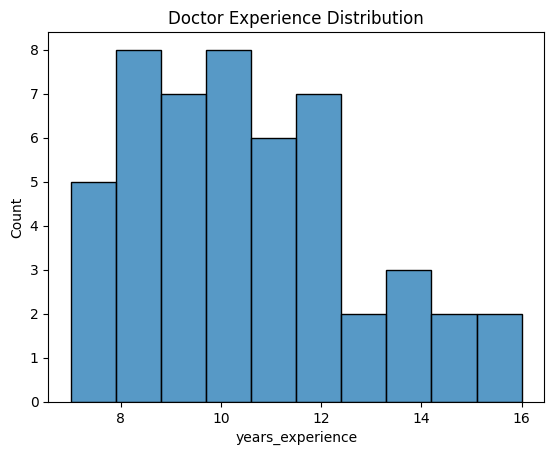

In [4]:
# Distribution of Experience
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(doctors['years_experience'], bins=10)
plt.title("Doctor Experience Distribution")
plt.show()


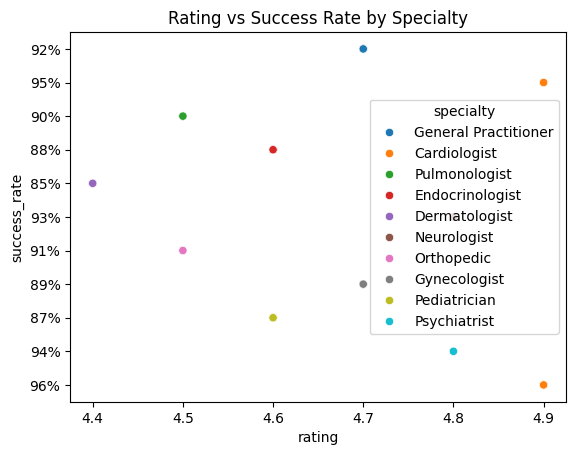

In [5]:
# Rating vs Success Rate
sns.scatterplot(
    x='rating',
    y='success_rate',
    hue='specialty',
    data=doctors
)
plt.title("Rating vs Success Rate by Specialty")
plt.show()


In [6]:
# Average Rating per Speciality
doctors.groupby('specialty')['rating'].mean().sort_values(ascending=False)


specialty
Cardiologist            4.9
Neurologist             4.8
Psychiatrist            4.8
Gynecologist            4.7
General Practitioner    4.7
Endocrinologist         4.6
Pediatrician            4.6
Orthopedic              4.5
Pulmonologist           4.5
Dermatologist           4.4
Name: rating, dtype: float64

## Patient Dataset EDA

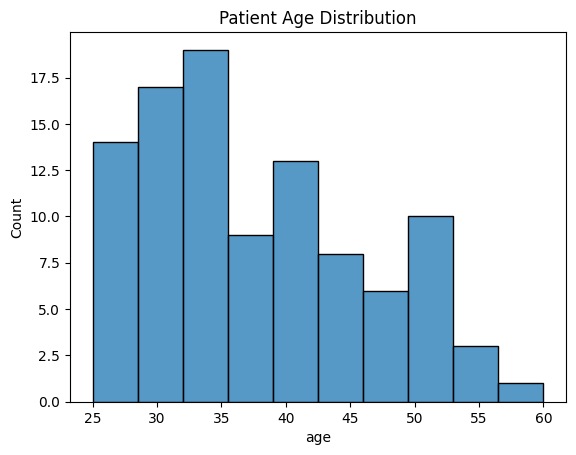

In [7]:
# Age Distribution
sns.histplot(patients['age'], bins=10)
plt.title("Patient Age Distribution")
plt.show()


In [8]:
# Chronic Condition Frequency
patients['chronic_conditions'].value_counts()


chronic_conditions
Diabetes         24
Asthma           20
Hypertension     18
Heart Disease    18
Name: count, dtype: int64

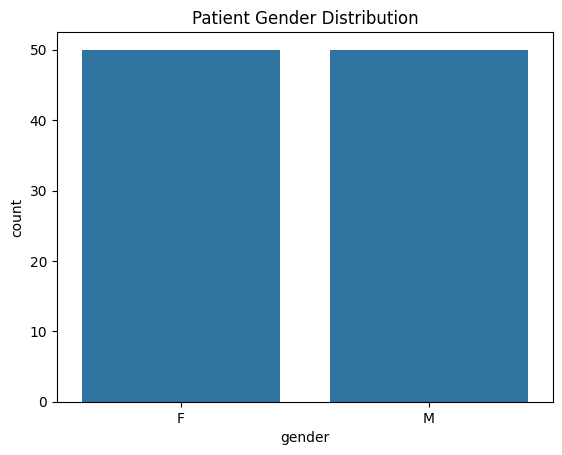

In [9]:
# Gender Distribution 
sns.countplot(x='gender', data=patients)
plt.title("Patient Gender Distribution")
plt.show()


### Data Merging

In [10]:
merged = patients.merge(doctors, how='cross')

## Feature Engineering

In [11]:
# Location Match
merged['location_match'] = (
    merged['location_x'] == merged['location_y']
).astype(int)


In [12]:
# Chronic Condition Presense
merged['has_chronic_condition'] = (
    merged['chronic_conditions'] != 'None'
).astype(int)


In [13]:
# Condition Speciality-Match
merged['condition_match'] = merged.apply(
    lambda x: int(
        x['has_chronic_condition'] == 1 and
        isinstance(x['chronic_conditions'], str) and
        x['specialty'].lower() in x['chronic_conditions'].lower()
    ),
    axis=1
)


In [14]:
# Experience Buckets
merged['experience_level'] = pd.cut(
    merged['years_experience'],
    bins=[0,5,10,20,50],
    labels=[0,1,2,3]
)


## EDA on Merge Data

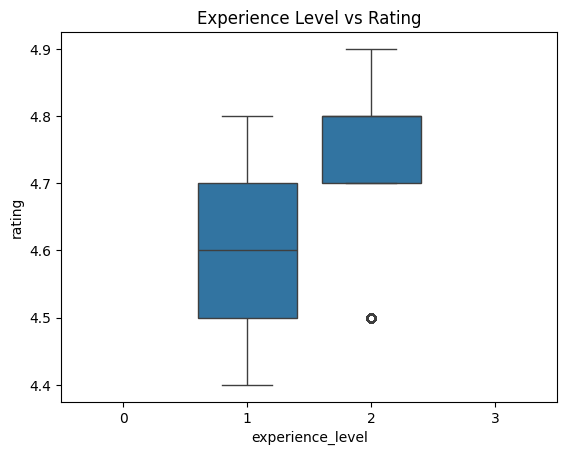

In [15]:
# Experience Vs Match
sns.boxplot(x='experience_level', y='rating', data=merged)
plt.title("Experience Level vs Rating")
plt.show()


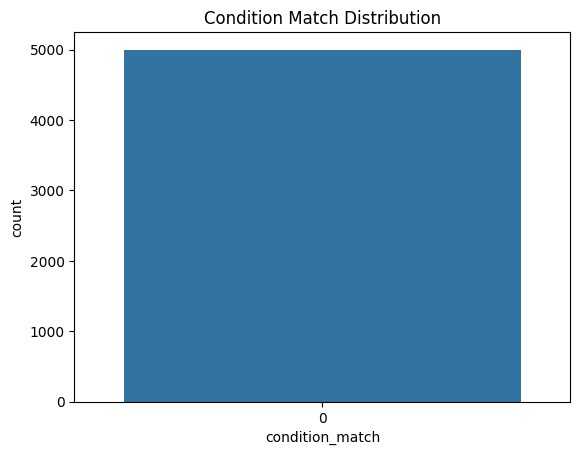

In [16]:
# Condition Match Impact
sns.countplot(x='condition_match', data=merged)
plt.title("Condition Match Distribution")
plt.show()


In [17]:
merged['success_rate'] = (
    merged['success_rate']
    .str.replace('%', '', regex=False)
    .astype(float)
)


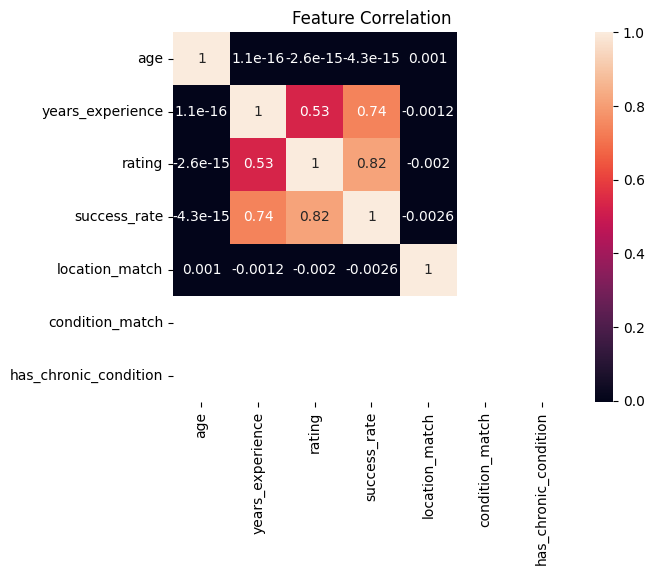

In [18]:
# Correlation Heatmap
corr = merged[
    ['age','years_experience','rating','success_rate',
     'location_match','condition_match','has_chronic_condition']
].corr()

sns.heatmap(corr, annot=True)
plt.title("Feature Correlation")
plt.show()


## Doctor Suitable Scale

In [19]:
merged['suitability_score'] = (
    merged['rating'] * 0.4 +
    merged['success_rate'] * 0.3 +
    merged['location_match'] * 0.2 +
    merged['condition_match'] * 0.1
)


In [20]:
# Binary Target
merged['target'] = (
    merged['suitability_score'] >
    merged['suitability_score'].median()
).astype(int)


## Preprocessing (Encoding & Scaling)

In [ ]:
!pip install -U scikit-learn


In [24]:
# Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
merged['gender'] = le.fit_transform(merged['gender'])
merged['specialty'] = le.fit_transform(merged['specialty'])
merged['consultation_type'] = le.fit_transform(merged['consultation_type'])


In [25]:
# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['age','years_experience','rating','success_rate']

merged[num_cols] = scaler.fit_transform(merged[num_cols])


## Feature Selection

In [26]:
features = [
    'age','gender','location_match','has_chronic_condition',
    'condition_match','years_experience','rating',
    'success_rate','experience_level','specialty'
]

X = merged[features]
y = merged['target']


## Model Training

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

## Model Evaluation

In [28]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [29]:
import pickle
import os

# ensure model directory exists
os.makedirs("../model", exist_ok=True)

# save files
pickle.dump(model, open("../model/doctor_model.pkl", "wb"))
pickle.dump(le, open("../model/label_encoder.pkl", "wb"))
pickle.dump(scaler, open("../model/scaler.pkl", "wb"))

print("Model and preprocessors saved successfully!")


Model and preprocessors saved successfully!
